In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import sys
# sys.path.append("..")
import splitwavepy as sw

import scipy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_noise(y):
    """
    Return a randomly simulated noise trace with similar spectral properties to y.
    """  
    # white noise
    x = np.random.normal(0,1,y.size)
    # convolve with y
    x = np.convolve(x,y,'same')
    # additional randomisation
    x = np.roll(x,np.random.randint(y.size))
    # whipeout near nyquist
    x = np.convolve(np.array([1,1,1]),x,'same')
    # normalise energy
    x = x * np.sqrt((np.sum(y**2) / np.sum(x**2)))
    # return
    return x


In [3]:
def bootstrap_sample(data,fast,lag):    
    # copy original data
    bs = data.copy()   
    origang = bs.angle
    # replace noise sequence
    bs.unsplit(fast,lag)
    bs.rotatetovecs(bs.pca())
    bs.y = get_noise(bs.y)
    bs.rotateto(origang)
    bs.split(fast,lag)
    return bs

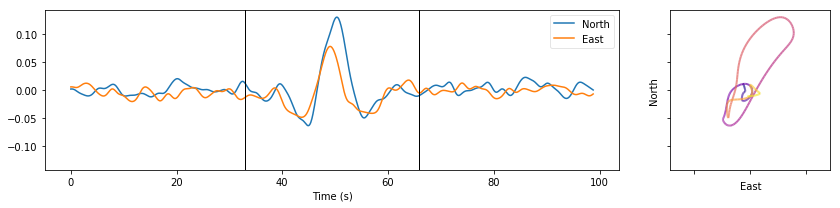

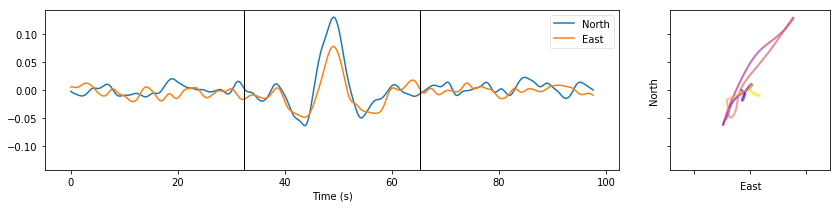

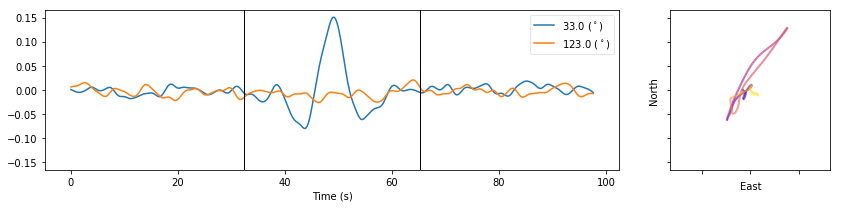

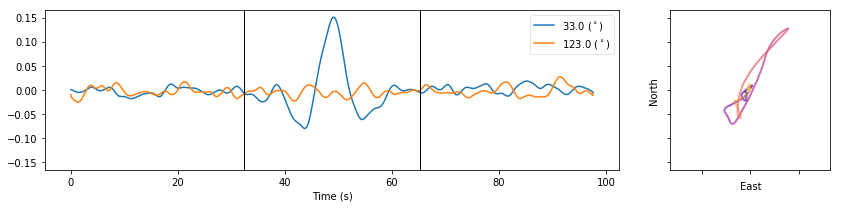

In [7]:
# def bootstrap_sample(data,fast,lag):    
# copy original data
fast=90
lag=1.2

a = sw.Pair(pol=30,delta=0.1,noise=0.05,split=(fast,lag))
a.data.plot()


a.data.unsplit(fast,lag)
a.data.plot()
a.data.rotatetovecs(a.data.pca())
a.data.plot(label='original data')
a.data.y = get_noise(a.data.y)
a.data.plot(title='new noise')
# a.data.rotateto(origang)
# a.data.split(fast,lag)
# a.data.plot()
#     return bs

In [ ]:
# a = sw.Pair(pol=10,delta=0.1,noise=0.05,fast=30,lag=1.2)
# a.plot()
b = bootstrap_sample(a,30,1.2)
b.plot()
# c = bootstrap_sample(a,30,1.2)
# c.plot()

In [ ]:
def bootstrap_loop(data,N=50):
    """
    Return list of bootstrap samples
    """        
    # initial measurement:
    m = sw.EigenM(data)
    mlags = m.tlags[:,0]
    mdegs = m.degs[0,:]
    # get probability surface to pick from
    # boost surf by **3 to enhance picks at peaks (value chosen by testing on synthetics)
    surf = (m.lam1/m.lam2)**3
    dlag = m.lags[1,0] - m.lags[0,0]
    density = rho(m.lags,dlag)
    surf = surf / density
    surf = surf / surf.sum()
    
    # pick fast and tlag from surf
    probs = surf.ravel()
    picks = np.random.choice(probs.size,size=N,replace=True,p=probs)
    idx = np.unravel_index(picks,surf.shape)
    
    # generate bootstrap sample measurements    
    bslist = [ sw.EigenM(bs,tlags=mlags,degs=mdegs) for bs in [ bootstrap_sample(data,degs,lags) for lags,degs in zip(m.tlags[idx],m.degs[idx]) ] ]
    return bslist

In [ ]:
def rho(n,step):
    if n == 0:
        return 1 / (np.pi/4 * step**2)
    elif n > 0:
        return 1 / (2 * np.pi * n * step)
    else:
        raise Exception('n not valid')
        
rho = np.vectorize(rho)

In [ ]:
m = sw.EigenM(a)

In [ ]:
m.plot()

In [ ]:
m.fast

In [ ]:
surf = (m.lam1/m.lam2)**3
dlag = m.lags[1,0] - m.lags[0,0]
density = rho(m.lags,dlag)
surf = surf/density
surf = surf / surf.sum()

In [ ]:
plt.contourf(m.tlags,m.degs,surf,26,cmap='magma')
plt.colorbar()

In [ ]:
probs = surf.ravel()
picks = np.random.choice(probs.size,size=50,replace=True,p=probs)
idx = np.unravel_index(picks,surf.shape)

In [ ]:
plt.contourf(m.tlags,m.degs,surf,26,cmap='viridis')
plt.scatter(m.tlags[idx],m.degs[idx])

In [ ]:
m.degs[idx]
m.tlags[idx]

In [ ]:
l = bootstrap_loop(a)

In [ ]:
v = [ m.lam1 / m.lam2 for m in l ]
stk = np.stack(v)

In [ ]:
plt.contourf(m.tlags,m.degs,stk.sum(axis=0),cmap='magma')

In [ ]:
a = sw.Pair(delta=0.1,fast=30,lag=1.5,noise=0.1)
a.plot()

In [ ]:
m = sw.EigenM(a)
m.plot()

In [ ]:
bs = bootstrap_loop(a,N=100)

In [ ]:
v = [ m.lam1 / m.lam2 for m in bs ]
stk = np.stack(v)
plt.contourf(m.tlags,m.degs,stk.sum(axis=0),26,cmap='magma')

In [ ]:
phis = [ m.fast for m in bs ]
lags = [ m.tlag for m in bs ]

In [ ]:
circstd = scipy.stats.circstd(2*np.deg2rad(phis))
print(0.5 * np.rad2deg(circstd))

lagstd = np.std(lags)
print(lagstd)

In [1]:
import splitwavepy as sw
import numpy as np
import matplotlib.pyplot as plt

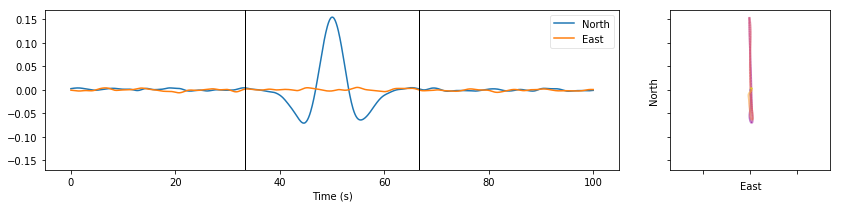

In [2]:
a = sw.Data(delta=0.1, noise=0.01)
a.plot()

In [3]:
x, y = a.chopdata()
idx = np.random.choice(a.window.width, a.window.width)
lam2, lam1 = sw.core.core.eigvalcov(x[idx], y[idx])

In [4]:
def _bootstrap_samp(x, y):
    idx = np.random.choice(x.size, x.size)
    return x[idx], y[idx]

bslist = [ sw.core.core.eigvalcov(*_bootstrap_samp(x, y)) for ii in range(50000) ]
bsarray = np.asarray(bslist)

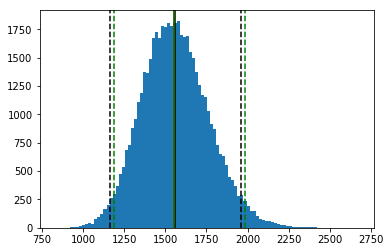

In [5]:
a = sw.Data(delta=0.1, noise=0.01)
x, y = a.chopdata()
bslist = [ sw.core.core.eigvalcov(*_bootstrap_samp(x, y)) for ii in range(50000) ]
bsarray = np.asarray(bslist)
plt.hist(bsarray[:,1]/bsarray[:,0], bins=100)
# the original measured lam1/lam2 in red
lam2, lam1 = sw.core.core.eigvalcov(x, y)
plt.axvline(lam1/lam2,color='r')
# the bootstrapmean lam1/lam2 in black
mean = np.mean(bsarray[:,1]/bsarray[:,0])
std = np.std(bsarray[:,1]/bsarray[:,0])
plt.axvline(mean, color='k')
plt.axvline(mean-1.96*std, color='k', linestyle='--')
plt.axvline(mean+1.96*std, color='k', linestyle='--')
# the bootstrap confidence limits
median = np.percentile(bsarray[:,1]/bsarray[:,0],50)
lower95 = np.percentile(bsarray[:,1]/bsarray[:,0],2.5)
upper95 = np.percentile(bsarray[:,1]/bsarray[:,0],97.5)
plt.axvline(median, color='g')
plt.axvline(lower95, color='g', linestyle='--')
plt.axvline(upper95, color='g', linestyle='--')
plt.show()

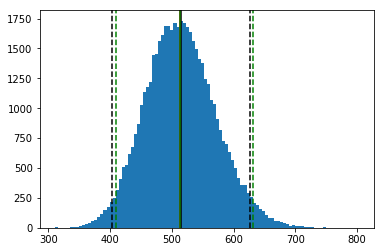

In [15]:
a = sw.Data(delta=0.1, noise=0.01)
x, y = a.chopdata()
bslist = [ sw.core.core.transenergy(*_bootstrap_samp(x, y)) for ii in range(50000) ]
bsarray = np.asarray(bslist)


lam1, lam2 = sw.core.core.transenergy(x, y)
plt.hist(bsarray[:,0]/bsarray[:,1], bins=100)

# the original measured lam1/lam2 in red
plt.axvline(lam1/lam2,color='r')
# the bootstrapmean lam1/lam2 in black
mean = np.mean(bsarray[:,0]/bsarray[:,1])
std = np.std(bsarray[:,0]/bsarray[:,1])
plt.axvline(mean, color='k')
plt.axvline(mean-1.96*std, color='k', linestyle='--')
plt.axvline(mean+1.96*std, color='k', linestyle='--')
# the bootstrap confidence limits
median = np.percentile(bsarray[:,0]/bsarray[:,1],50)
lower95 = np.percentile(bsarray[:,0]/bsarray[:,1],2.5)
upper95 = np.percentile(bsarray[:,0]/bsarray[:,1],97.5)
plt.axvline(median, color='g')
plt.axvline(lower95, color='g', linestyle='--')
plt.axvline(upper95, color='g', linestyle='--')
plt.show()

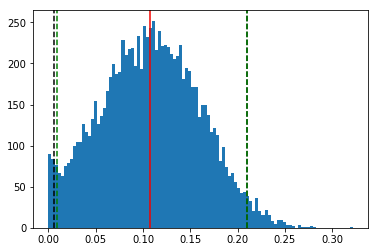

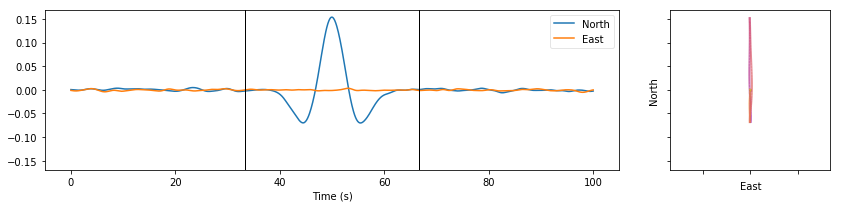

In [29]:
a = sw.Data(delta=0.1, noise=0.01)
x, y = a.chopdata()
xc = np.abs(sw.core.core.crosscorr(x, y))
bslist = [ sw.core.core.crosscorr(*_bootstrap_samp(x, y)) for ii in range(10000) ]
bsarray = np.abs(np.asarray(bslist))
plt.hist(bsarray, bins=100)

# the original measured lam1/lam2 in red
plt.axvline(xc, color='r')
# the bootstrapmean lam1/lam2 in black
mean = np.mean(bsarray)
std = np.std(bsarray)
plt.axvline(mean, color='k', alpha=0.02)
plt.axvline(mean-1.96*std, color='k', linestyle='--')
plt.axvline(mean+1.96*std, color='k', linestyle='--')
# the bootstrap confidence limits
median = np.percentile(bsarray,50)
lower95 = np.percentile(bsarray,2.5)
upper95 = np.percentile(bsarray,97.5)
plt.axvline(median, color='g', alpha=0.02)
plt.axvline(lower95, color='g', linestyle='--')
plt.axvline(upper95, color='g', linestyle='--')
plt.show()
a.plot()

# # the original measured lam1/lam2 in red
# plt.axvline(np.abs(xc), color='r')
# bsarray = np.abs(bsarray)
# plt.hist(bsarray, bins=100)
# # the bootstrapmean lam1/lam2 in black
# mean = np.mean(bsarray)
# std = np.std(bsarray)
# plt.axvline(mean, color='k')
# plt.axvline(mean-1.96*std, color='k', linestyle='--')
# plt.axvline(mean+1.96*std, color='k', linestyle='--')
# # the bootstrap confidence limits
# median = np.percentile(bsarray,50)
# lower95 = np.percentile(bsarray,2.5)
# upper95 = np.percentile(bsarray,97.5)
# plt.axvline(median, color='g')
# plt.axvline(lower95, color='g', linestyle='--')
# plt.axvline(upper95, color='g', linestyle='--')
# plt.show()

In [33]:
xc
# from scipy import stats
# stats.pearsonr(x,y)

array([ 0.10792344])

In [35]:
np.corrcoef(x,y)

array([[ 1.        , -0.11351543],
       [-0.11351543,  1.        ]])

In [36]:
sw.core.core.crosscorr(x, y)

array([-0.10792344])

In [37]:
%timeit sw.core.core.crosscorr(x, y)

13.9 µs ± 272 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [38]:
%timeit np.corrcoef(x,y)

75.2 µs ± 554 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [50]:
import math
def xcfunc(x, y):
    x = x - np.mean(x)
    y = y - np.mean(y)
    top = np.sum(x*y)
    bot = math.sqrt(np.sum(x**2) * np.sum(y**2))
    return top/bot

In [51]:
%timeit xcfunc(x, y)

36.4 µs ± 1.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [61]:
x2 = x - np.mean(x)
y2 = y - np.mean(y)

In [47]:
np.corrcoef(x2,y2)

array([[ 1.        , -0.11351543],
       [-0.11351543,  1.        ]])

In [49]:
xcfunc(x2, y2)

-0.113515433146559

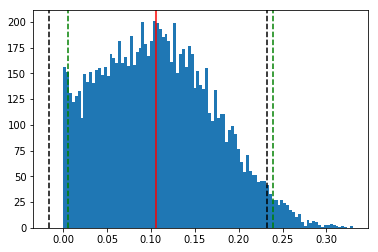

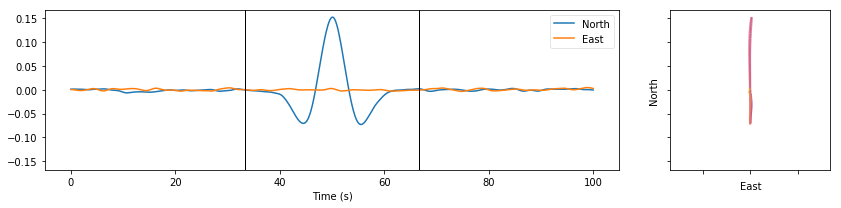

In [57]:
a = sw.Data(delta=0.1, noise=0.01)
x, y = a.chopdata()
xc = np.abs(xcfunc(x, y))
bslist = [ xcfunc(*_bootstrap_samp(x, y)) for ii in range(10000) ]
bsarray = np.abs(np.asarray(bslist))
plt.hist(bsarray, bins=100)

# the original measured lam1/lam2 in red
plt.axvline(xc, color='r')
# the bootstrapmean lam1/lam2 in black
mean = np.mean(bsarray)
std = np.std(bsarray)
plt.axvline(mean, color='k', alpha=0.02)
plt.axvline(mean-1.96*std, color='k', linestyle='--')
plt.axvline(mean+1.96*std, color='k', linestyle='--')
# the bootstrap confidence limits
median = np.percentile(bsarray,50)
lower95 = np.percentile(bsarray,2.5)
upper95 = np.percentile(bsarray,97.5)
plt.axvline(median, color='g', alpha=0.02)
plt.axvline(lower95, color='g', linestyle='--')
plt.axvline(upper95, color='g', linestyle='--')
plt.show()
a.plot()

In [60]:
sw.core.core.eigvalcov(x,y)

array([  1.52343907e-06,   3.03689154e-03])

In [62]:
sw.core.core.eigvalcov(x2,y2)

array([  1.52343907e-06,   3.03689154e-03])